In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
n = 2.5
c = 3e10
veff_true = c/n
veff_true*=1e-9
print(f"True v_eff = {veff_true:.2f} cm/ns")

True v_eff = 12.00 cm/ns


In [ ]:
N_EVENTS = 100000
strip_length = 49.6  # in cm
sigma_t = 0.5        # time resolution in ns

In [ ]:
lambdaa = 0.5 # absorption coefficient
d = 2 # in cm - detector thickness
filled = 0
r0 = 40 # in cm - detector radius
l = strip_length;

th_c = math.atan(l/(2*r0))
z_hit = []

while(filled<N_EVENTS):
  r = np.random.exponential(scale=1/lambdaa)
  theta = np.random.uniform(0, 2*np.pi)
  if r < d:
    if(theta<th_c or theta>2*np.pi-th_c):
      z_hit.append(r0*np.tan(theta))
      filled+=1

In [ ]:
z_hit = np.array(z_hit)

In [ ]:
t_hit = np.zeros(N_EVENTS)  # all photons created at same time

In [ ]:
tA = t_hit + (strip_length / 2 - z_hit) / veff_true + np.random.normal(0, sigma_t, N_EVENTS)
tB = t_hit + (strip_length / 2 + z_hit) / veff_true + np.random.normal(0, sigma_t, N_EVENTS)
tDIFF = tB - tA

In [ ]:
bins = 300
hist, bin_edges = np.histogram(tDIFF, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

In [ ]:
threshold = 0.3 * np.max(hist)
indices = np.where(hist > threshold)[0]
edge_left = bin_centers[indices[0]]
edge_right = bin_centers[indices[-1]]

In [ ]:
delta_t = np.abs(edge_right - edge_left)
veff_estimated = (2 * strip_length) / delta_t

In [ ]:
print(f"True v_eff      = {veff_true:.2f} cm/ns")
print(f"Estimated v_eff = {veff_estimated:.2f} cm/ns")
print(f"Time edges      = {edge_left:.2f} ns to {edge_right:.2f} ns")

True v_eff      = 12.00 cm/ns
Estimated v_eff = 11.59 cm/ns
Time edges      = -4.18 ns to 4.39 ns


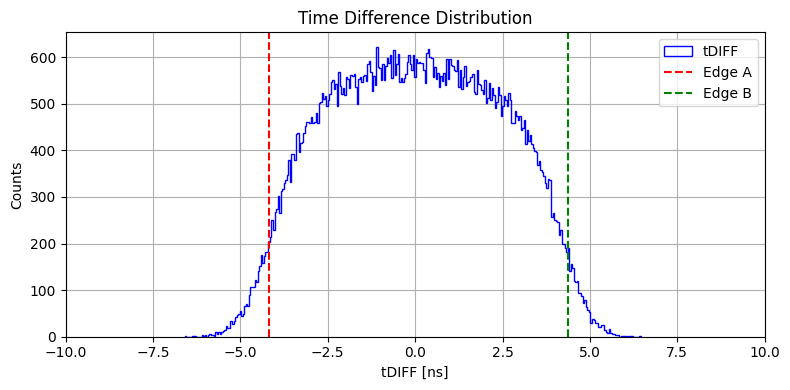

In [ ]:
plt.figure(figsize=(8, 4))

plt.hist(tDIFF, bins=bins, histtype='step', color='blue', label='tDIFF')

plt.axvline(edge_left, color='red', linestyle='--', label='Edge A')
plt.axvline(edge_right, color='green', linestyle='--', label='Edge B')

plt.title("Time Difference Distribution")
plt.xlabel("tDIFF [ns]")
plt.ylabel("Counts")
plt.xlim(-10,10)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## What threshold should I choose? 🤔

In [ ]:
thresholds = np.linspace(0.01, 0.5, 50)  # 50 points from 1% to 50%
veff_estimates = []
veff_errors = []

In [ ]:
for thresh in thresholds:
    threshold_value = thresh * np.max(hist)
    indices = np.where(hist > threshold_value)[0]
    edge_left = bin_centers[indices[0]]
    edge_right = bin_centers[indices[-1]]
    delta_t = np.abs(edge_right - edge_left)
    veff_estimated = (2 * strip_length) / delta_t
    veff_error = np.abs(veff_estimated - veff_true)
    veff_estimates.append(veff_estimated)
    veff_errors.append(veff_error)

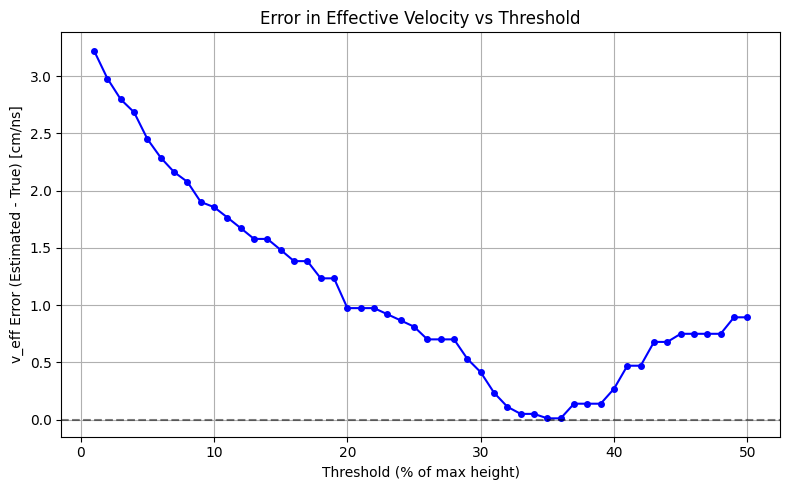

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds * 100, veff_errors, 'b-', marker='o', markersize=4)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title("Error in Effective Velocity vs Threshold")
plt.xlabel("Threshold (% of max height)")
plt.ylabel("v_eff Error (Estimated - True) [cm/ns]")
plt.grid(True)
plt.tight_layout()

## Okay, So it's an optimization problem, let's try brute-force. 🐵

In [ ]:
optimal_idx = np.argmin(veff_errors)
optimal_threshold = thresholds[optimal_idx]
optimal_error = veff_errors[optimal_idx]
optimal_veff = veff_estimates[optimal_idx]

In [ ]:
print(f"True v_eff: {veff_true:.2f} cm/ns")
print(f"Optimal threshold: {optimal_threshold*100:.2f}%")
print(f"Estimated v_eff at optimal: {optimal_veff:.2f} cm/ns")
print(f"Absolute error at optimal: {optimal_error:.4f} cm/ns")

True v_eff: 12.00 cm/ns
Optimal threshold: 35.00%
Estimated v_eff at optimal: 12.01 cm/ns
Absolute error at optimal: 0.0120 cm/ns


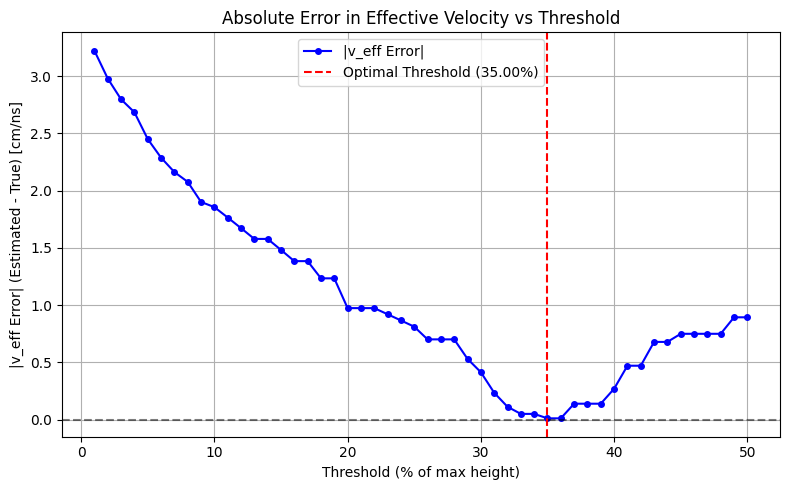

In [ ]:
plt.figure(figsize=(8, 5))

plt.plot(thresholds * 100, veff_errors, 'b-', marker='o', markersize=4, label='|v_eff Error|')

plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.axvline(optimal_threshold * 100, color='red', linestyle='--',label=f'Optimal Threshold ({optimal_threshold*100:.2f}%)')

plt.title("Absolute Error in Effective Velocity vs Threshold")
plt.xlabel("Threshold (% of max height)")
plt.ylabel("|v_eff Error| (Estimated - True) [cm/ns]")

plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

## Let's see if brent's method works. 🐣

In [ ]:
from scipy.optimize import minimize_scalar

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html

https://en.wikipedia.org/wiki/Brent%27s_method

https://people.duke.edu/~ccc14/sta-663/OptimizationInOneDimension.html

In [ ]:
def error_function(thresh):
    threshold_value = thresh * np.max(hist)
    indices = np.where(hist > threshold_value)[0]
    edge_left = bin_centers[indices[0]]
    edge_right = bin_centers[indices[-1]]
    delta_t = np.abs(edge_right - edge_left)
    veff_estimated = (2 * strip_length) / delta_t
    return np.abs(veff_estimated - veff_true)

In [ ]:
result = minimize_scalar(error_function, bounds=(0.01, 0.5), method='bounded')
optimal_threshold = result.x
optimal_error = result.fun

In [ ]:
optimal_threshold

np.float64(0.3734396301921324)

In [ ]:
optimal_error

np.float64(0.1398217593808173)

## Task: Check how the optimal_threshold is changing with the sigma_t.

Change sigma_t from 0.05 ns to 1 ns.

In [ ]:
def optimal_threshold(ini,fin):
  result = minimize_scalar(error_function,bounds=(ini,fin),method="bounded")
  return result.x

In [ ]:
sigma_t_list = np.linspace(0.05,1,100)
optimal_thresholds = []

for sigma_t in sigma_t_list:
  tA = (strip_length / 2 - z_hit) / veff_true + np.random.normal(0, sigma_t, N_EVENTS)
  tB = (strip_length / 2 + z_hit) / veff_true + np.random.normal(0, sigma_t, N_EVENTS)

  tDIFF = tB - tA

  bins = 300
  hist, bin_edges = np.histogram(tDIFF, bins=bins)
  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

  threshold = 0.3 * np.max(hist)
  indices = np.where(hist > threshold)[0]
  edge_left = bin_centers[indices[0]]
  edge_right = bin_centers[indices[-1]]

  delta_t = np.abs(edge_right - edge_left)
  veff_estimated = (2 * strip_length) / delta_t

  optimal_thresholds.append(optimal_threshold(0.01,0.5))

In [ ]:
len(hist)

300

In [ ]:
optimal_thresholds = np.array(optimal_thresholds)

In [ ]:
len(optimal_thresholds)

100

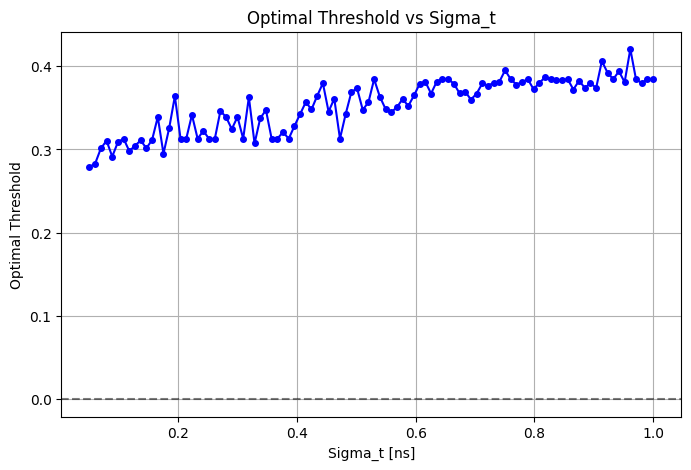

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(sigma_t_list, optimal_thresholds, 'b-', marker='o', markersize=4)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.title("Optimal Threshold vs Sigma_t")
plt.xlabel("Sigma_t [ns]")
plt.ylabel("Optimal Threshold")
plt.grid(True)

## Task: Plot the v_eff_error vs sigma_t for a 0.3 threshold

In [ ]:
sigma_t_list = np.linspace(0.05,1,100)
v_eff_error = []

for sigma_t in sigma_t_list:
  tA = (strip_length / 2 - z_hit) / veff_true + np.random.normal(0, sigma_t, N_EVENTS)
  tB = (strip_length / 2 + z_hit) / veff_true + np.random.normal(0, sigma_t, N_EVENTS)

  tDIFF = tB - tA

  bins = 300
  hist, bin_edges = np.histogram(tDIFF, bins=bins)
  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

  threshold = 0.3 * np.max(hist)
  indices = np.where(hist > threshold)[0]
  edge_left = bin_centers[indices[0]]
  edge_right = bin_centers[indices[-1]]

  delta_t = np.abs(edge_right - edge_left)
  veff_estimated = (2 * strip_length) / delta_t

  v_eff_error.append(np.abs(veff_estimated - veff_true))

  #optimal_thresholds.append(optimal_threshold(0.01,0.5))

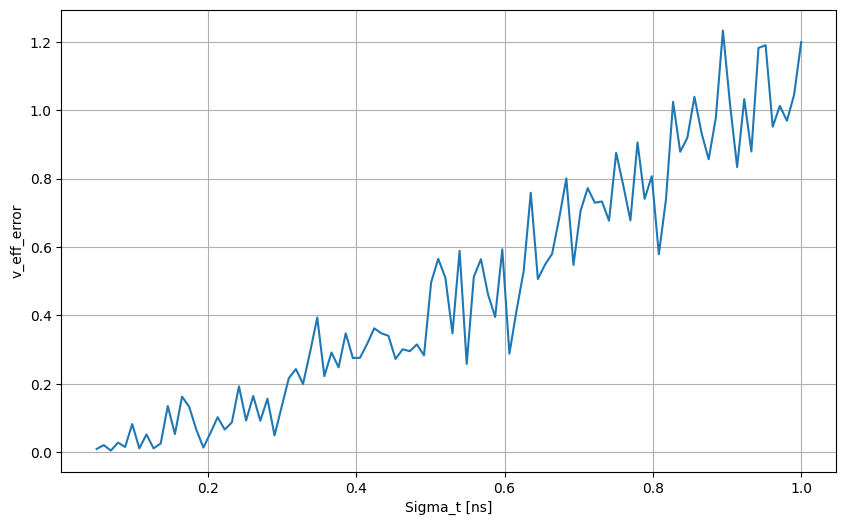

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(sigma_t_list, v_eff_error)
plt.xlabel("Sigma_t [ns]")
plt.ylabel("v_eff_error")
plt.grid(True)
#plt.ylim(0,5)